# **BCG X Capstone Project** 
<img src="https://web-assets.bcg.com/1a/1f/6b52570e4ba49920815bdda88e36/bcgx-meet-banner.jpg" alt="drawing" style="width:800px; height:300px"/>

### **Calculating RFM and Client Segmentation and Analysis Notebook**

**Group members**

Morten Aas-Lyngby, Paolo Brambillasca,  Ignacio Alonso Lopez-Linares, Emilio Jair Rodriguez Capitan, Alberto Dona

**Notebook description**

This notebook provides the fourth step in our Analysis. 
It focusses on segmenting the customers based on the RFM framework and analyse the cohorts. We will also deep dive into the Customer LifeTime Value.

**Problem definition**

The Team has been tasked with building a Churn Model to increase CLTV as well as to help ClienCo. in their product cross-selling strategy and demand forecasting problem.

# Table of Contents

1. [Importing necessary Libraries](#1-importing-necessary-libraries)
2. [Calculating Recency-Frequency-Monetary](#2-calculating-recency-frequency-monetary)
   - [2.1 Introduction](#21-introduction)
   - [2.2 Calculating the fields](#22-calculating-the-fields)
   - [2.3 Rank the features!](#23-rank-the-features)
   - [2.4 Score and Create Segments - Weighted Score towards Monetary Values](#24-score-and-create-segments---weighted-score-towards-monetary-values)
3. [Customer Life Time Value Analysis](#3-customer-life-time-value-analysis)
   - [3.1 Group clients by segment & Calculate Churn Rate](#31-group-clients-by-segment--calculate-churn-rate)
   - [3.2 Calculate Retention Factor](#32-calculate-retention-factor)
   - [3.3 Calculate CLV](#33-calculate-clv)


### **1. Importing necessary Libraries**

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

### **2. Calculating Recency-Frequency-Monetary**

Methodology:
- Calculate recency, frequency and monetary value.
- Rank the customers for each of the features
- Normalize the ranked features from 0 to 100.
- Calculate RFM score and segment. We will later use the RFM segments to calculate the CLV. Therefore we decided to weigh recency 20%, frequency 20% and monetary value 60%. The groups will then be separated mostly based on the monetary value, and will give a more accurate CLV.

For RFM we will use the following definitions:
- Recency: Days since the clients last purchase up until 2019-09-22.
- Frequency: Total purchases made by the customer
- Monetary value: Total spend by the customer

Reference: RFM analysis using Python

Source: https://www.geeksforgeeks.org/rfm-analysis-analysis-using-python/

#### 2.1 Introduction

In [2]:
data = pd.read_parquet('data/transactions_cleaned')
data = data[data['sales_net'] > 0]

In [3]:
data.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,invoice_delay,sales_per_quantity,order_year,order_month,order_day_month,order_day_week,order_period,monthly_sales,previous_month_sales
0,2017-09-25,2017-09-25,2376333,188502,155.443207,3,online,2732,0.0,51.814400,2017,September,25,Monday,2017-09,86852728.0,86852728.0
1,2017-09-25,2017-09-25,2520527,835089,16.394400,3,at the store,10279,0.0,5.464800,2017,September,25,Monday,2017-09,86852728.0,86852728.0
2,2017-09-25,2017-09-25,2536756,1977896,365.766235,21,online,6184,0.0,17.417440,2017,September,25,Monday,2017-09,86852728.0,86852728.0
3,2017-09-25,2017-09-25,3028673,598816,8.598780,201,at the store,4200,0.0,0.042780,2017,September,25,Monday,2017-09,86852728.0,86852728.0
4,2017-09-25,2017-09-25,203377,2086861,1093.374023,3,by phone,7051,0.0,364.458008,2017,September,25,Monday,2017-09,86852728.0,86852728.0


In [4]:
data = data[['date_order', 'client_id', 'sales_net']]
data['date_order'] = pd.to_datetime(data['date_order'])
data.head()

,date_order,client_id,sales_net
0,2017-09-25,188502,155.443207
1,2017-09-25,835089,16.394400
2,2017-09-25,1977896,365.766235
3,2017-09-25,598816,8.598780
4,2017-09-25,2086861,1093.374023


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57169057 entries, 0 to 61780196
Data columns (total 3 columns):
 #   Column      Dtype         
---  ------      -----         
 0   date_order  datetime64[ns]
 1   client_id   int32         
 2   sales_net   float32       
dtypes: datetime64[ns](1), float32(1), int32(1)
memory usage: 1.3 GB


#### 2.2 Calculating the fields

In [6]:
recency = data.groupby(by='client_id', as_index=False)['date_order'].max()

recency.columns = ['client_id', 'LastPurchaseDate']

cut_off = '2019-09-22'
cut_off = dt.datetime.strptime(cut_off, '%Y-%m-%d')

recency['recency'] = recency['LastPurchaseDate'].apply(lambda x: (cut_off - x).days)
recency.head()

,client_id,LastPurchaseDate,recency
0,6,2019-08-13,40
1,7,2018-12-24,272
2,14,2019-09-20,2
3,18,2019-09-12,10
4,25,2018-10-10,347


In [7]:
frequency = data.groupby(by=['client_id'])['date_order'].count().reset_index()
frequency.columns = ['client_id', 'frequency']
frequency.head()

,client_id,frequency
0,6,36
1,7,15
2,14,11948
3,18,1975
4,25,4


In [8]:
monetary_value = data.groupby(by=['client_id'])['sales_net'].sum().reset_index()
monetary_value.columns = ['client_id', 'monetary_value']
monetary_value.head()

,client_id,monetary_value
0,6,5.882233e+03
1,7,1.190777e+03
2,14,3.095639e+06
3,18,2.440798e+05
4,25,3.745861e+02


In [9]:
rfm = recency.merge(frequency, on='client_id', how='outer').merge(monetary_value, on='client_id', how='outer')
rfm.drop(['LastPurchaseDate'], axis = 1, inplace = True)
rfm.head()

,client_id,recency,frequency,monetary_value
0,6,40,36,5.882233e+03
1,7,272,15,1.190777e+03
2,14,2,11948,3.095639e+06
3,18,10,1975,2.440798e+05
4,25,347,4,3.745861e+02


#### 2.3 Rank the features!

In [10]:
rfm['R_rank'] = rfm['recency'].rank(ascending=False)
rfm['F_rank'] = rfm['frequency'].rank(ascending=True)
rfm['M_rank'] = rfm['monetary_value'].rank(ascending=True)
rfm.head()

,client_id,recency,frequency,monetary_value,R_rank,F_rank,M_rank
0,6,40,36,5.882233e+03,89917.0,78769.5,81810.0
1,7,272,15,1.190777e+03,38894.5,52804.0,38792.0
2,14,2,11948,3.095639e+06,165661.0,170226.0,170431.0
3,18,10,1975,2.440798e+05,140524.5,164757.0,162270.0
4,25,347,4,3.745861e+02,30186.5,22132.0,18060.0


In [11]:
rfm['R_rank_norm'] = (rfm['R_rank']/rfm['R_rank'].max())*100
rfm['F_rank_norm'] = (rfm['F_rank']/rfm['F_rank'].max())*100
rfm['M_rank_norm'] = (rfm['F_rank']/rfm['M_rank'].max())*100
rfm.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
rfm.head()

,client_id,recency,frequency,monetary_value,R_rank_norm,F_rank_norm,M_rank_norm
0,6,40,36,5.882233e+03,52.715910,46.175829,46.175829
1,7,272,15,1.190777e+03,22.802795,30.954475,30.954475
2,14,2,11948,3.095639e+06,97.122572,99.788963,99.788963
3,18,10,1975,2.440798e+05,82.385721,96.582955,96.582955
4,25,347,4,3.745861e+02,17.697530,12.974101,12.974101


#### 2.4 Score and Create Segments - Weighted Score towards Monetary Values

Remember the pareto! We will prioritise Monetary fields

In [12]:
rfm['RFM_Score'] = 0.20*rfm['R_rank_norm']+ \
                    0.20 * rfm['F_rank_norm']+ \
                    0.60*rfm['M_rank_norm']

rfm['RFM_Score'] *= 0.05

rfm = rfm.round(2)
rfm[['client_id', 'RFM_Score']].head()

,client_id,RFM_Score
0,6,2.37
1,7,1.47
2,14,4.96
3,18,4.69
4,25,0.70


In [13]:
def plot_elbow(data, title):
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title(f'Elbow Method for {title}')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.show()

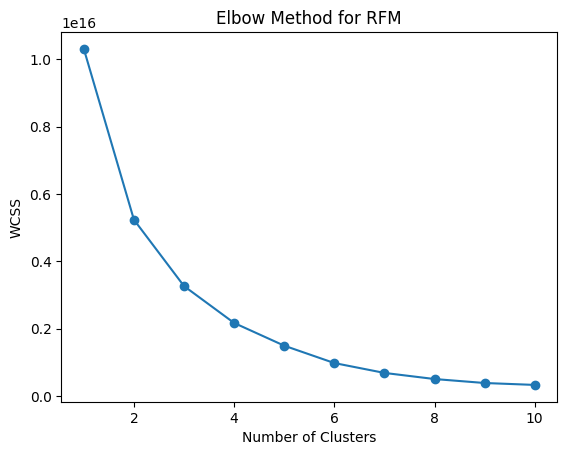

In [14]:
plot_elbow((rfm[['recency', 'frequency', 'monetary_value']]), 'RFM')

In [15]:
rfm["Customer_segment"] = np.where(rfm['RFM_Score'] >4.5, "Top Customers",
                                      (np.where(rfm['RFM_Score'] > 4, "High value Customer",
                                      (np.where(rfm['RFM_Score'] > 3,"Medium Value Customer",
                                      np.where(rfm['RFM_Score'] > 1.6, 'Low Value Customers', 'Lost Customers'))))))

rfm[['client_id', 'RFM_Score', 'Customer_segment']].head()

,client_id,RFM_Score,Customer_segment
0,6,2.37,Low Value Customers
1,7,1.47,Lost Customers
2,14,4.96,Top Customers
3,18,4.69,Top Customers
4,25,0.70,Lost Customers


In [16]:
rfm['Customer_segment'].value_counts(normalize = True)

Customer_segment
Lost Customers           0.309181
Low Value Customers      0.303401
Medium Value Customer    0.208628
High value Customer      0.095922
Top Customers            0.082867
Name: proportion, dtype: float64

In [17]:
rfm['Customer_segment'].value_counts()

Customer_segment
Lost Customers           52742
Low Value Customers      51756
Medium Value Customer    35589
High value Customer      16363
Top Customers            14136
Name: count, dtype: int64

In [18]:
rfm.head()

,client_id,recency,frequency,monetary_value,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment
0,6,40,36,5.882230e+03,52.72,46.18,46.18,2.37,Low Value Customers
1,7,272,15,1.190780e+03,22.80,30.95,30.95,1.47,Lost Customers
2,14,2,11948,3.095639e+06,97.12,99.79,99.79,4.96,Top Customers
3,18,10,1975,2.440798e+05,82.39,96.58,96.58,4.69,Top Customers
4,25,347,4,3.745900e+02,17.70,12.97,12.97,0.70,Lost Customers


In [19]:
segments = rfm[['client_id', 'Customer_segment']]
segments.to_csv('data/segments.csv')
rfm.to_csv('data/rfm.csv')

### **3. Customer Life Time Value Analysis**

To calculate the CLV we will use the monetary value and segments from the RFM. We also need to calculate a retention rate, for which we will use the churn labels from the same dataset as we used for our model.

We used the whole time period in the dataset for our calculations. Using a time period of two years starting and stopping in september is not a conventional approach, but we felt it necessary to use the whole period to more accurate churn rate for the high value and top customers.

The CLV for the segments with a low churn rate is overestimated for two reasons. The first reason is that ee did not use a discount rate for the CLV, which means that the segments and clients that we expect will be customers for longer will be overvalued. The second reason is that the segments are based on only two years. If a customer that on a longer time frame would be high value or top customer churns in an early part of the time frame (within year one for example), the customer will not be segmented as top of high value customer. Therefore the churn in these two segments are most likely underrepresented. This gives a higher retention factor and therefore a higher CLV.

Methodology:
- Group clients by segment.
- Calculate rate of churn.
- Calculate retention factor.
- Calculate CLV.

#### 3.1 Group clients by segment & Calculate Churn Rate

In [22]:
rfm = pd.read_csv('data/rfm.csv')
labeled = pd.read_parquet('data/Final_grouped_with_churn')

In [23]:
rfm.head()

,Unnamed: 0,client_id,recency,frequency,monetary_value,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment
0,0,6,40,36,5882.23,52.72,46.18,46.18,2.37,Low Value Customers
1,1,7,272,15,1190.78,22.80,30.95,30.95,1.47,Lost Customers
2,2,14,2,11948,3095638.80,97.12,99.79,99.79,4.96,Top Customers
3,3,18,10,1975,244079.84,82.39,96.58,96.58,4.69,Top Customers
4,4,25,347,4,374.59,17.70,12.97,12.97,0.70,Lost Customers


In [24]:
labeled.head()

,client_id,first_order_date,last_order_date,total_sales,total_quantity,num_tickets,num_negative_tickets,sum_negative_sales,sum_positive_sales,unique_branches,max_days_between_orders,total_period,recency,avg_days_between_orders,std_days_between_orders,monthly_frequency,avg_sale_value,refunds_per_ticket,refunds_percentage,avg_ticket_quantity,sales_total_with_respect_to_total_sales,median_days_between_orders,churn_recency_max,single_order_churn,churn_max
0,6,2017-10-27,2019-08-13,5.882233e+03,3038,40,0,0.000000,5.882233e+03,1,194.0,655,40,16.794872,44.097488,1.832061,147.055817,0.000000,0.000000,75.949997,6.416573e-07,0.0,0,0,0
1,7,2018-07-16,2018-12-24,1.190777e+03,99,15,0,0.000000,1.190777e+03,1,161.0,161,272,11.500000,43.029060,2.795031,79.385139,0.000000,0.000000,6.600000,1.298947e-07,0.0,1,0,1
2,14,2017-09-25,2019-09-20,3.043896e+06,1362031,12339,73,-51743.144531,3.095638e+06,9,10.0,725,2,0.058762,0.341219,510.579315,246.689011,0.005916,-0.016715,110.384232,3.320402e-04,0.0,0,0,0
3,18,2017-09-26,2019-09-12,2.180872e+05,72186,2194,147,-25992.683594,2.440798e+05,2,26.0,716,10,0.326493,1.260038,91.927376,99.401619,0.067001,-0.106493,32.901550,2.378981e-05,0.0,0,0,0
4,25,2018-10-10,2018-10-10,3.745861e+02,108,4,0,0.000000,3.745861e+02,1,0.0,0,347,0.000000,0.000000,inf,93.646530,0.000000,0.000000,27.000000,4.086134e-08,0.0,1,0,1


In [25]:
rfm = rfm[['client_id', 'recency', 'frequency','monetary_value', 'Customer_segment']]
labeled = labeled[['client_id', 'churn_max']]

In [26]:
rfm_labeled = rfm.merge(labeled, on = 'client_id', how = 'left')
rfm_labeled.head()

,client_id,recency,frequency,monetary_value,Customer_segment,churn_max
0,6,40,36,5882.23,Low Value Customers,0
1,7,272,15,1190.78,Lost Customers,1
2,14,2,11948,3095638.80,Top Customers,0
3,18,10,1975,244079.84,Top Customers,0
4,25,347,4,374.59,Lost Customers,1


In [27]:
sort_order = {
    'Top Customers': 1,
    'High value Customer': 2,
    'Medium Value Customer': 3,
    'Low Value Customers': 4,
    'Lost Customers': 5
}

groups = rfm_labeled.groupby('Customer_segment').agg({
    'client_id': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': 'mean',
    'churn_max': lambda x: (x == 1).sum()
}).reset_index()

groups.rename(columns={'client_id': 'number of clients', 'churn_max': 'number of churned'}, inplace=True)

# Add a sort key based on the custom sort order
groups['sort_key'] = groups['Customer_segment'].map(sort_order)

# Sort by the sort key and drop the sort key column
groups = groups.sort_values('sort_key').drop(columns='sort_key')

groups['churn_rate'] = (groups['number of churned'] / groups['number of clients']).round(3)

#### 3.2 Calculate Retention Factor

In [28]:
groups

,Customer_segment,number of clients,recency,frequency,monetary_value,number of churned,churn_rate
4,Top Customers,14136,4.719228,2755.719793,447561.732848,181,0.013
0,High value Customer,16363,14.168612,558.254293,101964.866920,645,0.039
3,Medium Value Customer,35589,52.106494,184.992413,33928.924936,4796,0.135
2,Low Value Customers,51756,126.956102,41.850703,8413.371251,15359,0.297
1,Lost Customers,52742,325.642088,6.252455,1822.397354,37300,0.707


In [29]:
groups['retention_factor'] = (1-groups['churn_rate']) / (groups['churn_rate'])
groups.head()

,Customer_segment,number of clients,recency,frequency,monetary_value,number of churned,churn_rate,retention_factor
4,Top Customers,14136,4.719228,2755.719793,447561.732848,181,0.013,75.923077
0,High value Customer,16363,14.168612,558.254293,101964.866920,645,0.039,24.641026
3,Medium Value Customer,35589,52.106494,184.992413,33928.924936,4796,0.135,6.407407
2,Low Value Customers,51756,126.956102,41.850703,8413.371251,15359,0.297,2.367003
1,Lost Customers,52742,325.642088,6.252455,1822.397354,37300,0.707,0.414427


#### 3.3 Calculate CLV

In [30]:
groups['CLV'] = groups['monetary_value'] * groups['retention_factor']
groups.head()

,Customer_segment,number of clients,recency,frequency,monetary_value,number of churned,churn_rate,retention_factor,CLV
4,Top Customers,14136,4.719228,2755.719793,447561.732848,181,0.013,75.923077,3.398026e+07
0,High value Customer,16363,14.168612,558.254293,101964.866920,645,0.039,24.641026,2.512519e+06
3,Medium Value Customer,35589,52.106494,184.992413,33928.924936,4796,0.135,6.407407,2.173964e+05
2,Low Value Customers,51756,126.956102,41.850703,8413.371251,15359,0.297,2.367003,1.991448e+04
1,Lost Customers,52742,325.642088,6.252455,1822.397354,37300,0.707,0.414427,7.552510e+02


In [31]:
client_segment = rfm_labeled[['client_id', 'Customer_segment']]
client_segment.head()

,client_id,Customer_segment
0,6,Low Value Customers
1,7,Lost Customers
2,14,Top Customers
3,18,Top Customers
4,25,Lost Customers


In [32]:
clients_segments_CLV = client_segment.merge(groups[['Customer_segment', 'CLV']], on = 'Customer_segment', how = 'left')
clients_segments_CLV.head()

,client_id,Customer_segment,CLV
0,6,Low Value Customers,1.991448e+04
1,7,Lost Customers,7.552510e+02
2,14,Top Customers,3.398026e+07
3,18,Top Customers,3.398026e+07
4,25,Lost Customers,7.552510e+02


In [33]:
groups.to_csv('data/CLV.csv')
clients_segments_CLV.to_csv('data/clients_segments_CLV.csv')